<a href="https://colab.research.google.com/github/sbutori/autoestudo-semana-05/blob/main/Autoestudo_Semana_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das Bibliotecas Necessárias

In [20]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully 

In [18]:
import os
import requests
import zipfile
from d2l import tensorflow as d2l
import pandas as pd
import tensorflow as tf

# Download do conjunto de dados Tatoeba

## Criar um diretório para os dados

In [2]:
data_dir = 'data/tatoeba'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Baixar o dataset do Tatoeba

In [3]:
url = "http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip"
dataset_path = os.path.join(data_dir, 'tatoeba.zip')

## Fazer o download dos dados

In [4]:
if not os.path.exists(dataset_path):
    print("Baixando o dataset...")
    response = requests.get(url)
    with open(dataset_path, 'wb') as f:
        f.write(response.content)

Baixando o dataset...


## Descompactar o dataset

In [5]:
print(dataset_path)

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print("Dataset baixado e extraído.")

data/tatoeba/tatoeba.zip
Dataset baixado e extraído.


# Pré-processamento

## Carregar o arquivo em memória

In [21]:
file_path = '/content/data/tatoeba/fra-eng/fra.txt'

def read_data_nmt():
    """Carregar o dataset inglês-francês."""
    with open(os.path.join(file_path), 'r') as f:
        return f.read()

raw_text = read_data_nmt()

## Ajustes no texto conforme orientações da seção 9.5

In [7]:
def preprocess_nmt(text):
    """Pré-processamento do dataset inglês-francês."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Substituir 'non-breaking spaces' com espaços e converter texto para lowercase
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Inserir espaço entre as palavras e pontuações
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)

# Tokenização

In [8]:
def tokenize_nmt(text, num_examples=None):
    """Tokenizar o dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

### Número de sequências no dataset (eixo y) por Quantidade de tokens (eixo x)

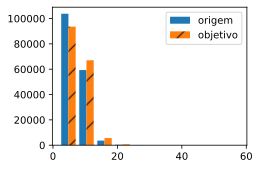

In [14]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['origem', 'objetivo'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

# Obtenção do vocabulário

In [13]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [16]:
def truncate_pad(line, num_steps, padding_token):
    """Truncar ou fazer o padding das sequências."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncar
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

# Treinamento do modelo

In [40]:
def build_array_nmt(lines, vocab, num_steps):
    """Transforma sequências de texto de tradução automática em minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(
        tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

In [41]:
def load_data_nmt(batch_size, num_steps, num_examples=1):
    """Retorna o iterador e os vocabulários do conjunto de dados de tradução."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [42]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tf.Tensor(
[[4 0 2 3 3 3 3 3]
 [4 0 2 3 3 3 3 3]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([3 3], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[4 0 2 3 3 3 3 3]
 [4 0 2 3 3 3 3 3]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([3 3], shape=(2,), dtype=int32)
